<a href="https://colab.research.google.com/github/aayush9753/MyProjects/blob/main/DigitRecognition_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the drive to get the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imprting the libraries

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random
import math
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim import lr_scheduler, Adam, SGD

import torch.nn.functional as F
from torch.autograd import Variable

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import os
import copy

# Importing the Data

In [3]:
train=pd.read_csv('/content/drive/My Drive/Data/Digit_Recognition/train.csv')
test=pd.read_csv('/content/drive/My Drive/Data/Digit_Recognition/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Preprocessing the Raw Data
As the Data is having 785 columns which have m 28*28*1 images and their labels.
We are converting the data in aproper format to feed them in the model.


In [5]:
#Getting the label column
train_labels = np.array(train['label'])
# m = No of Exaples
m_train = train.shape[0] #m in training data
m_test = test.shape[0]  #m in testing data
#reshaping the long 1D vector of shape 1*784 into a 3D vector of shape 1*28*28 
train_data = np.array(train.loc[:,'pixel0':]).reshape(m_train,1,28,28)
test_data = np.array(test.loc[:,'pixel0':]).reshape(m_test,1,28,28)

#Visualising the Data

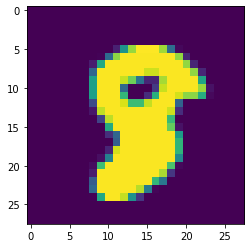

The label for the above image is 8


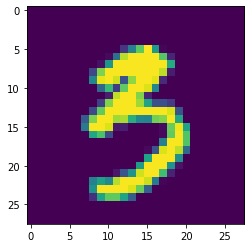

The label for the above image is 3


In [7]:
k = 0
while k<2:
    i = random.randint(0,42000)
    plt.imshow(train_data[i,0,:,:])
    plt.show()
    print(f"The label for the above image is {train_labels[i]}")
    k+=1

### Splitting the data into Training, Validation and Testing Set
We are using 90% data for training, 5% for Validation and 5% for Testing purpose.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

###Transformer
 Making a Transformer to convert our data into the PyTorch Tensors and Normalize the data.
 We are converting the data with Mean = 0.5 and STD = 0.5 across the channel

In [9]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### Dataset

In [11]:
class DigitDataset(Dataset):

    def __init__(self,images,labels,transfrom = transform):
        # Initialize data, download, etc.
        self.x_data = torch.from_numpy(images/255.) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(labels) # size [n_samples, 1]
        self.n_samples = images.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [12]:
train_dataset = DigitDataset(X_train,y_train)
val_dataset = DigitDataset(X_val,y_val)
test_dataset = DigitDataset(X_test,y_test)

### Creating Dataloaders
We will use Batch-Size = 64

In [14]:
batch_size=64
# defining trainloader, valloader and testloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

##### Visualising the Data-loaders

In [15]:
# shape of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


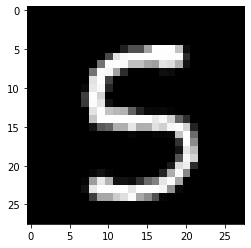

In [16]:
# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [17]:
# shape of validation data
dataiter = iter(val_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [18]:
#Checking the device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Model Building
Our Model is taking 1*28*28 Images as input and having the output with dimension = 10

In [20]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

Defining the Optimizer, Criterion (loss function) and Learning Rate Scheduler.

In [21]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


## Training of the model

In [24]:
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(val_dataset)

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time() #Return the time in seconds since the epoch as a floating point number

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataloaders = {}
    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:

model = model.to(device)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0592 Acc: 0.9807
val Loss: 0.0921 Acc: 0.9671

Epoch 1/49
----------
train Loss: 0.0410 Acc: 0.9872
val Loss: 0.0708 Acc: 0.9786

Epoch 2/49
----------
train Loss: 0.0382 Acc: 0.9879
val Loss: 0.0698 Acc: 0.9781

Epoch 3/49
----------
train Loss: 0.0364 Acc: 0.9885
val Loss: 0.0696 Acc: 0.9776

Epoch 4/49
----------
train Loss: 0.0361 Acc: 0.9886
val Loss: 0.0723 Acc: 0.9762

Epoch 5/49
----------
train Loss: 0.0346 Acc: 0.9894
val Loss: 0.0699 Acc: 0.9795

Epoch 6/49
----------
train Loss: 0.0349 Acc: 0.9894
val Loss: 0.0701 Acc: 0.9771

Epoch 7/49
----------
train Loss: 0.0344 Acc: 0.9891
val Loss: 0.0689 Acc: 0.9771

Epoch 8/49
----------
train Loss: 0.0315 Acc: 0.9905
val Loss: 0.0683 Acc: 0.9790

Epoch 9/49
----------
train Loss: 0.0313 Acc: 0.9906
val Loss: 0.0683 Acc: 0.9795

Epoch 10/49
----------
train Loss: 0.0312 Acc: 0.9910
val Loss: 0.0685 Acc: 0.9800

Epoch 11/49
----------
train Loss: 0.0313 Acc: 0.9907
val Loss: 0.0685 Acc: 0.9790

Ep

### Testing our model on test-data

In [30]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    images = images.cuda()
    images = images.type(torch.cuda.FloatTensor)
    labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 2100

Model Accuracy = 0.9795238095238096


### Predicting for unlabelled Data

In [34]:
test = test_data/255 #Normalizing the data
test = torch.from_numpy(test)  # Converting into Tensors
test = test.type(torch.cuda.FloatTensor) 

In [35]:
with torch.no_grad():
  outputs = model(test.cuda())

Outputs are the output of the final linear Layer having shape = 10

In [36]:
ps = torch.exp(outputs)

In [42]:
#max_value is the value of highest no. in each 10-dim vector 
#index is the index of that max value 
max_value, index = torch.max(ps,axis=1) 

In [44]:
index = index.cpu()
#Converting Prediction to numpy for Submission
prediction = index.numpy()

In [45]:
prediction.shape

(28000,)

In [46]:
k = np.arange(1,28001)

Saving the Prediction in the acceptable format 

In [47]:
submission = pd.DataFrame({
        "ImageId":k ,
        "Label": prediction

    })

submission.to_csv('Digit_Recognition_submission.csv', index=False)